# Inequality in the world through the lenses of HIV/AIDS
## Statistical analysis of the HIV global epidemic in the years 1990 - 2019 

### Introduction and motivation
The HIV/AIDS global epidemic caused more than 32 million deaths since its beginning in the 1980s. Being a sexually trasmitted desease that was mostly connected to the gay man community it was very much silenced by the media.

In 1987 the first antiretroviral drug effective in the treatment of HIV was developed. At the beginning of the 1990s this and other drugs became available and patients effectively started to be cured. These days an HIV diagnosis might not be a death sentence as it was in the early days of the pandemic. According to a study carried out by UNAIDS, the number of new infections decreased by 35\% for MSM (men who have sex with men) and \50% for heterosexual people. This sounds very positive, however, it is only the bright side. HIV/AIDS is still a death threat for people living in low and middle income countries, where access to antiretroviral is not as widespread as in the high income countries. 

Therefore, the HIV/AIDS is no longer a widespread disease, but a reflection of the inequality in the world. Unfortunately, the more vulnerable groups are still at very high risk of contracting HIV. Every week 6,200 young women aged 15-24 worldwide are infected by HIV.

**<font size="2">The small print</font> <font size="5">made large</font>** 

This study is no way intended to be a comprehensive analysis of the HIV global epidemic, which is a very complicated problem. This analysis is intended as an exercise to practice data science and machine learning technique. 

In [1]:
#First the imports, always.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import cycler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import missingno as msno 
import seaborn as sb
from IPython.display import Markdown

In [2]:
#Some matplotlib settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
#The following colours are used throughout the notebook for displaying data.
#They were selected from the website colorbrewer2.org, which provides palettes for people suffering from 
#color vision deficiency. If these do not work for you please change the list below.
plt.rcParams['axes.prop_cycle'] = cycler(color=['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b']) 

In [3]:
#Import data from the csv files and check their heads
hiv_per_thous_data = pd.read_csv('data/HIV_total.csv', skiprows=4, index_col=0) #THIS IS THE ORIGINAL ONE
hiv_per_thous_data = hiv_per_thous_data.drop(columns=['Indicator Name','Country Code', 'Indicator Code'])
gdp_per_capita_data = pd.read_csv('data/GDP_per_capita.csv', skiprows=4, index_col=0)
gdp_per_capita_data = gdp_per_capita_data.drop(columns=['Indicator Name','Country Code', 'Indicator Code'])

#drop rows and columns that contain only NaN
hiv_per_thous_data = hiv_per_thous_data.dropna(axis = 1, how='all')
hiv_per_thous_data = hiv_per_thous_data.dropna(axis = 0, how='all')
gdp_per_capita_data = gdp_per_capita_data.dropna(axis = 1, how='all')
gdp_per_capita_data = gdp_per_capita_data.dropna(axis = 0, how='all')

#Drop "World". The datasets used in this analysis also contain a row about the worls. 
#The goal of this study is analysing the inequality among different countries. Therefore, the worldwide value is o
hiv_per_thous_data = hiv_per_thous_data.drop('World')

In [4]:
#Transform the HIV data from per thousand to percent (for simplicity of notation)
hiv_percent_data = hiv_per_thous_data/10

In [5]:
#Check the columns are ordered
hiv_percent_data = hiv_percent_data.reindex(sorted(hiv_percent_data.columns), axis=1)
gdp_per_capita_data = gdp_per_capita_data.reindex(sorted(gdp_per_capita_data.columns), axis=1)

In [6]:
# Function to identify the common columns and rows
def common_data(df1,df2,how=''):
    if how == 'column':
        col1 = df1.columns
        col2 = df2.columns
        common_timeframe = col1.intersection(col2).to_list()
        return common_timeframe
    elif how == 'index':
        idx1 = df1.index
        idx2 = df2.index
        common_countries = idx1.intersection(idx2).to_list()
        return common_countries
    else:
        return 'Please specify along which dimension'

In [7]:
# This cell slices the dfs so we are left with the common elements only
common_countries = common_data(hiv_percent_data,gdp_per_capita_data,how='index')
common_timeframe = common_data(hiv_percent_data,gdp_per_capita_data,how='column')
hiv_percent = hiv_percent_data.loc[common_countries,common_timeframe]
gdp_per_capita = gdp_per_capita_data.loc[common_countries,common_timeframe]

In [8]:
# Now let's deal with the NaN elements left. Is there any?
print('Total number of NaN values in the HIV dataset: ', hiv_percent.isnull().sum().sum())
print('Total number of NaN values in the GDP dataset: ', gdp_per_capita.isnull().sum().sum())

Total number of NaN values in the HIV dataset:  195
Total number of NaN values in the GDP dataset:  171


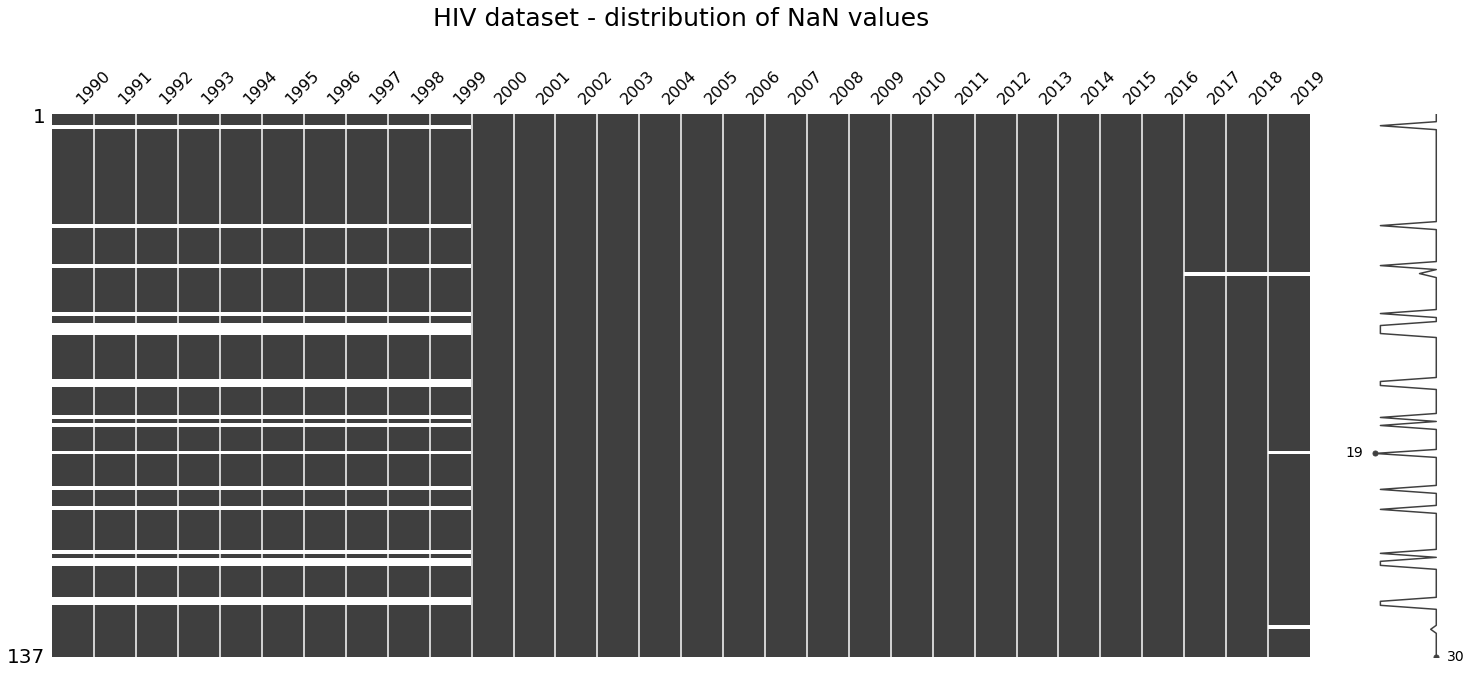

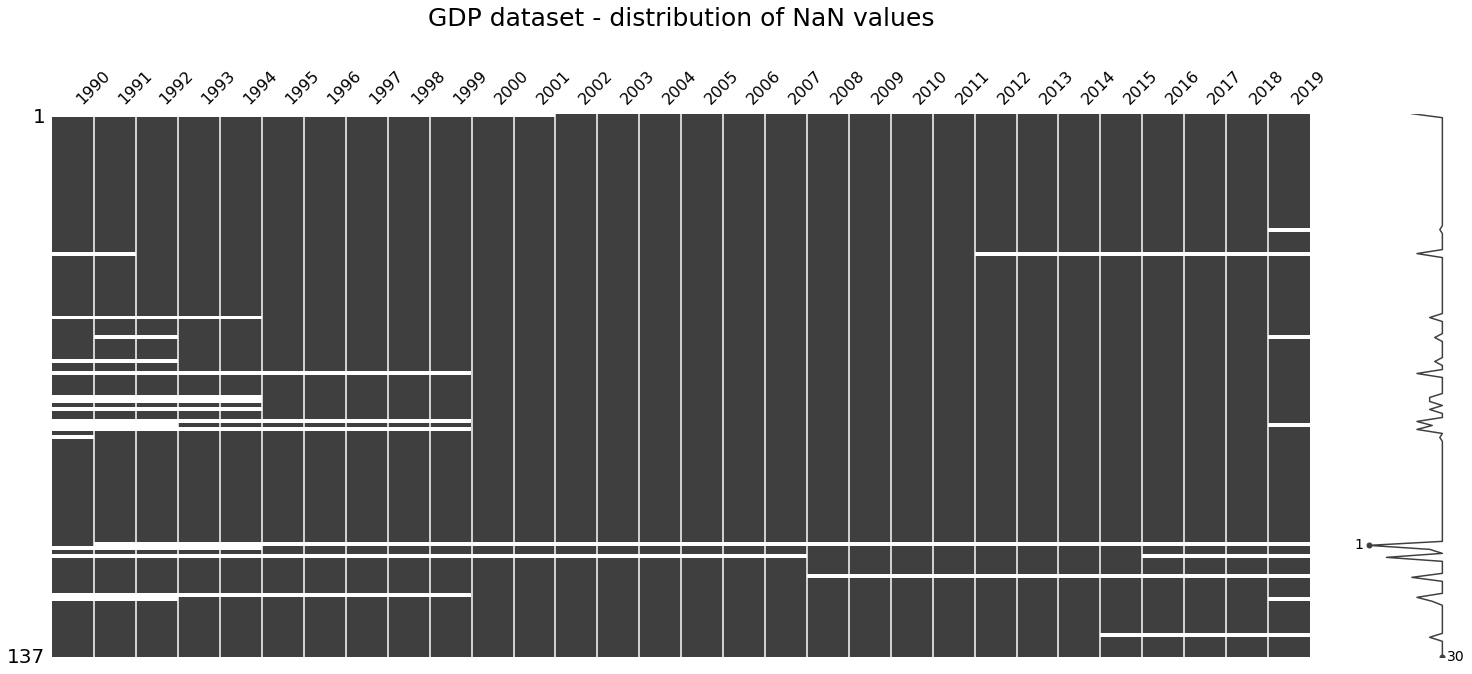

In [9]:
#Let's visualise the distribution of the NaN values.
#The msno function plots a graph where NaN values are displayed as white spaces.
msno.matrix(hiv_percent);
plt.title('HIV dataset - distribution of NaN values', size = 25).set_position([.5, 1.15])
msno.matrix(gdp_per_capita);
plt.title('GDP dataset - distribution of NaN values', size = 25).set_position([.5, 1.15])

In [10]:
#Now that I have a better undestranding of my data I decide to use dropna how=any
hiv_percent = hiv_percent.loc[:,common_timeframe].dropna('index',how='any')  
gdp_per_capita = gdp_per_capita.loc[:,common_timeframe].dropna('index',how='any')

In [11]:
#And I need to select the common countries again
common_countries = common_data(hiv_percent,gdp_per_capita,how='index')
hiv_percent = hiv_percent.loc[common_countries,:]
gdp_per_capita = gdp_per_capita.loc[common_countries,:]
print('Number of countries: ',hiv_percent.shape[0])
print('Number   of   years: ',hiv_percent.shape[1])

Number of countries:  97
Number   of   years:  30


## Analysis on the HIV data

<Figure size 1440x576 with 0 Axes>

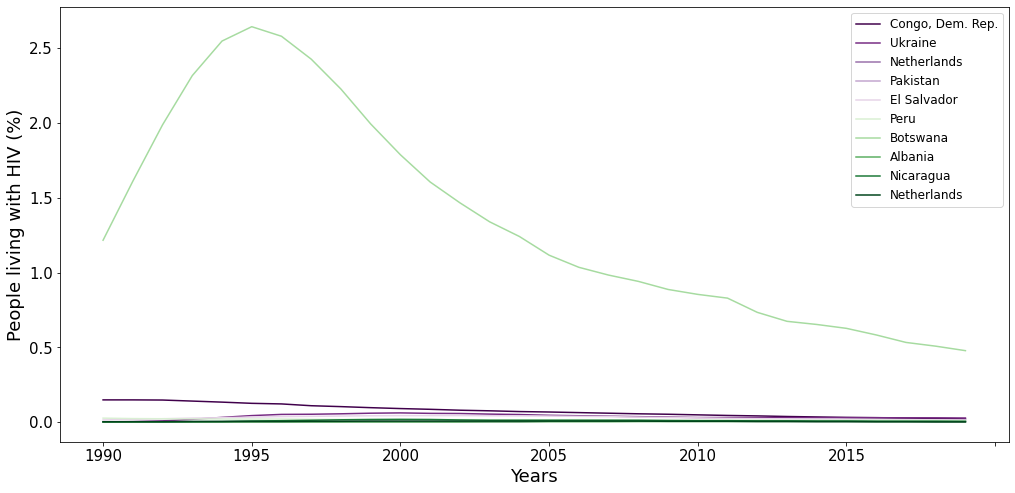

In [12]:
#Let's plot some data now...
#Plot some a randomly chosen sample of 10 countries (%HIV vs year)
plt.figure();
sample = np.random.choice(hiv_percent.index.size, size=10, replace=True);
hiv_percent_sample = hiv_percent.iloc[sample,:];
hiv_percent_sample_fig = hiv_percent_sample.T.plot(figsize=(17,8));
plt.legend(bbox_to_anchor=(1, 1.0));
plt.xlabel('Years');
plt.ylabel('People living with HIV (%)');

### Principal component analysis (PCA) on HIV data

,Variance,Cum Variance %,Residual Variance %
Component,,,
1,0.917185,91.718476,8.281524
2,0.065636,98.282124,1.717876
3,0.009088,99.190921,0.809079
4,0.004947,99.685621,0.314379
5,0.002641,99.949723,0.050277


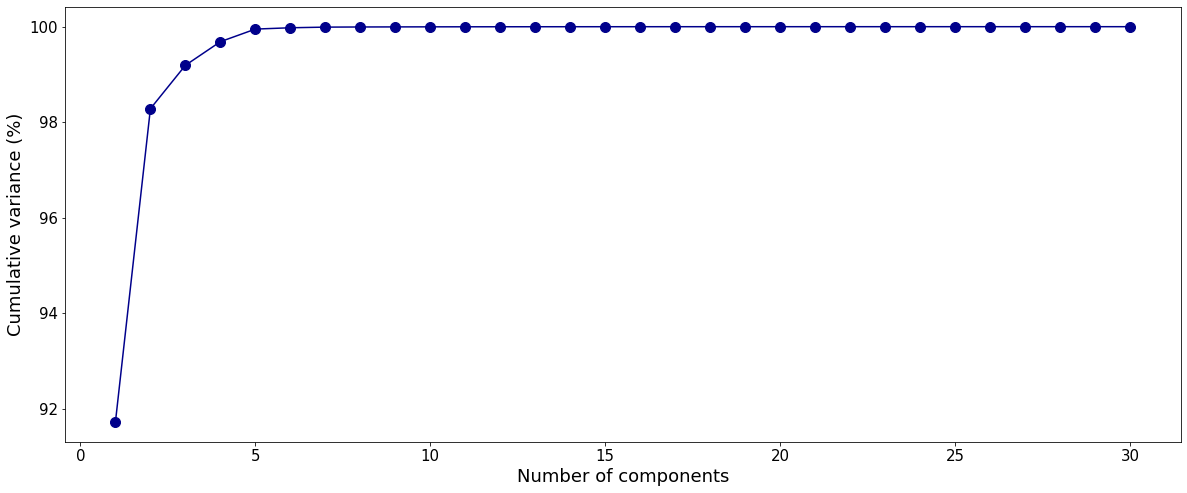

In [13]:
#In order to perform a PCA, the components must be first scaled
hiv_percent_scaled = StandardScaler().fit_transform(hiv_percent)

#I run to calculate the cumulative variance and choose the number of components to include
pca = PCA()
X_pca = pca.fit(hiv_percent_scaled)

#Show the variance in a table
variance_df = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'])
variance_df['Cum Variance %'] = pca.explained_variance_ratio_.cumsum()*100
variance_df['Residual Variance %'] = (1-pca.explained_variance_ratio_.cumsum())*100
variance_df.index += 1
variance_df.index.name = 'Component'
display(variance_df.head())

#Plot the cumulative variance 
plt.plot(variance_df['Cum Variance %'], marker='o', markersize=10, linestyle = '-', c='DarkBlue')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance (%)');

Based on the above observations I am going to use 4 components. This way 99.59\% of the variance is retained.

In [14]:
#Now I perform a PCA with four components
num_components = 4
pca = PCA(num_components)  
X_pca = pca.fit_transform(hiv_percent_scaled)

#This is saved in a DataFrame and its head is displayed here
hiv_percent_pca4 = pd.DataFrame(X_pca, columns =['PC1','PC2','PC3','PC4'] , index = hiv_percent.index)
hiv_percent_pca4.head()

,PC1,PC2,PC3,PC4
Country Name,,,,
Angola,-0.659097,-0.896923,0.535276,-0.169363
Albania,-2.553029,-0.180995,-0.083616,0.058138
Argentina,-2.296034,-0.197238,-0.032017,0.013028
Armenia,-2.452669,-0.219345,-0.090470,0.066939
Australia,-2.521092,-0.158097,-0.079244,0.058115


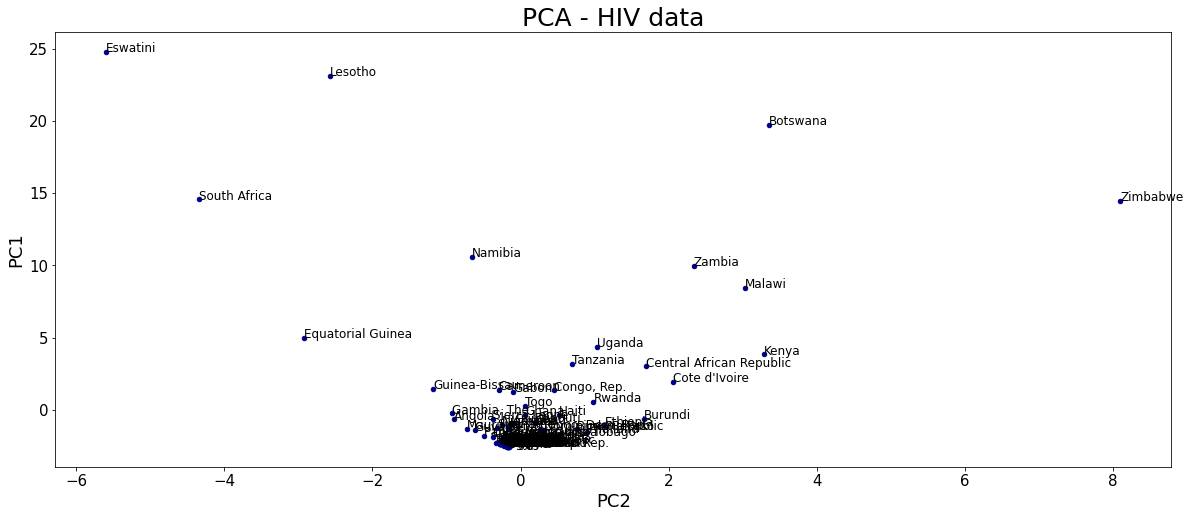

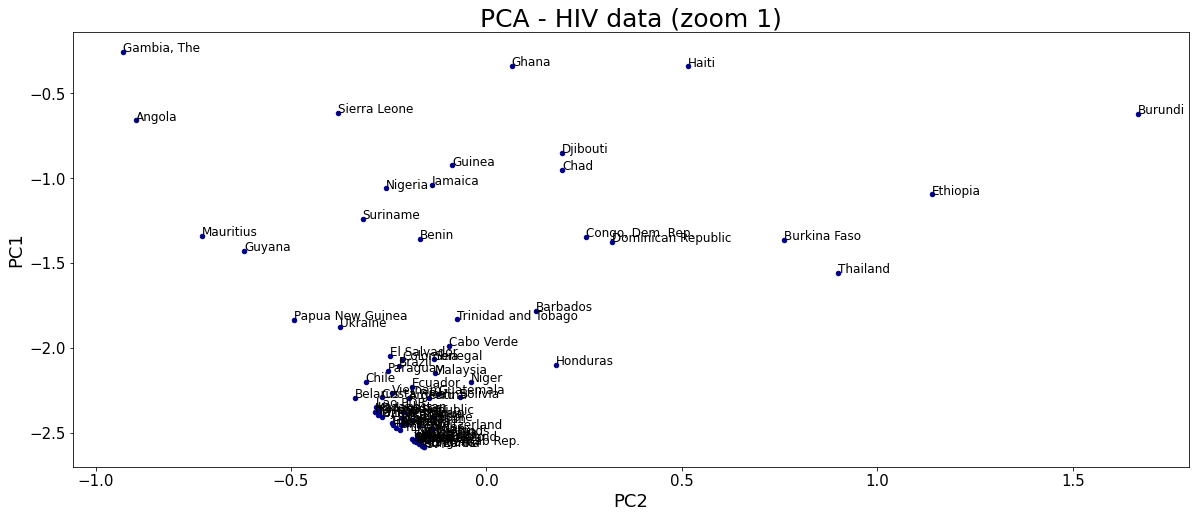

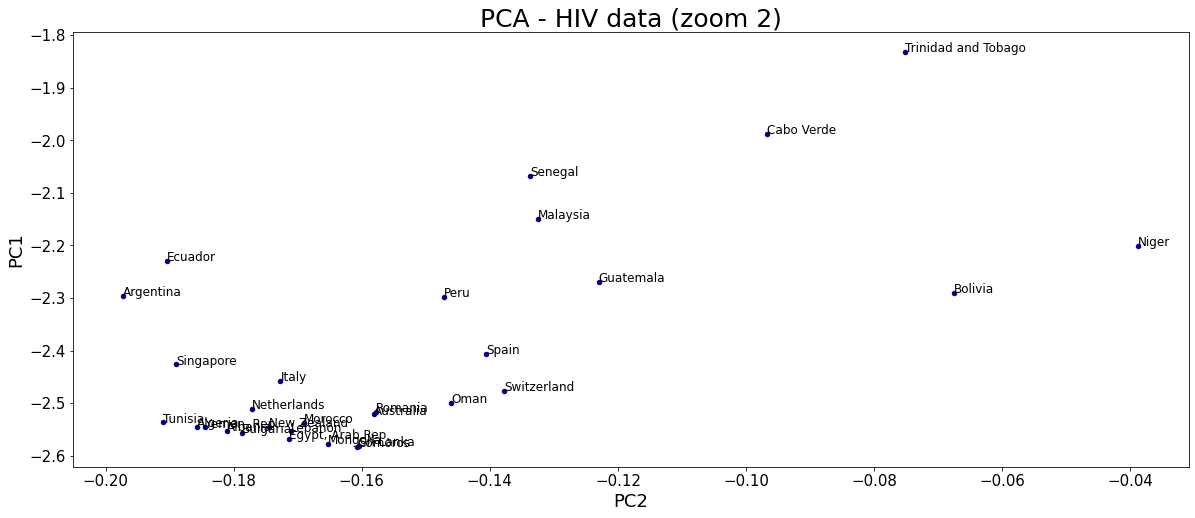

In [15]:
#Display data on a scatter plot for PC1 and PC2 (the PC that retain the highest variance)
#Since most of the points are concentrated in one region, three plots are displayed.
#The first one includes all the data. The second and third are zoom ins of the regions with the highest concentration of datapoints.
hiv_pca_fig = hiv_percent_pca4.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

for i, country in enumerate(hiv_percent_pca4.index):
    hiv_pca_fig.annotate(country, (hiv_percent_pca4.iloc[i].PC2, hiv_percent_pca4.iloc[i].PC1),fontsize=12)

hiv_pca_fig.set_xlabel('PC2');
hiv_pca_fig.set_ylabel('PC1');
plt.title('PCA - HIV data', size = 25).set_position([.5, 1.])
##############################################
zoom1_df  = hiv_percent_pca4 
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC1 > 0.0].index)
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC2 > 2.0].index)
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC2 < -2.0].index)


hiv_pca_fig_zoom1 = zoom1_df.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

for i, country in enumerate(zoom1_df.index):
    hiv_pca_fig_zoom1.annotate(country, (zoom1_df.iloc[i].PC2, zoom1_df.iloc[i].PC1),fontsize=12)

hiv_pca_fig_zoom1.set_xlabel('PC2');
hiv_pca_fig_zoom1.set_ylabel('PC1');
plt.title('PCA - HIV data (zoom 1)', size = 25).set_position([.5, 1.]);
###################################################

zoom2_df  = hiv_percent_pca4 
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC1 > -1.75].index)
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC2 > 0.1].index)
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC2 < -0.2].index)

#plt.figure();
hiv_pca_fig_zoom2 = zoom2_df.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

for i, country in enumerate(zoom2_df.index):
    hiv_pca_fig_zoom2.annotate(country, (zoom2_df.iloc[i].PC2, zoom2_df.iloc[i].PC1),fontsize=12)

hiv_pca_fig_zoom2.set_xlabel('PC2');
hiv_pca_fig_zoom2.set_ylabel('PC1');
plt.title('PCA - HIV data (zoom 2)', size = 25).set_position([.5, 1.]);

### Extracting information from the PCA

Now I want to visualise the original data for points that have very different values of PC1 and PC2. I choose four countries that represent extreme values of the two PCs keeping the other one constant. South Africa and Zimbabwe have a similar PC1 value and well separated values for PC2. The opposite is true for Lesotho and Equatorial Guinea.


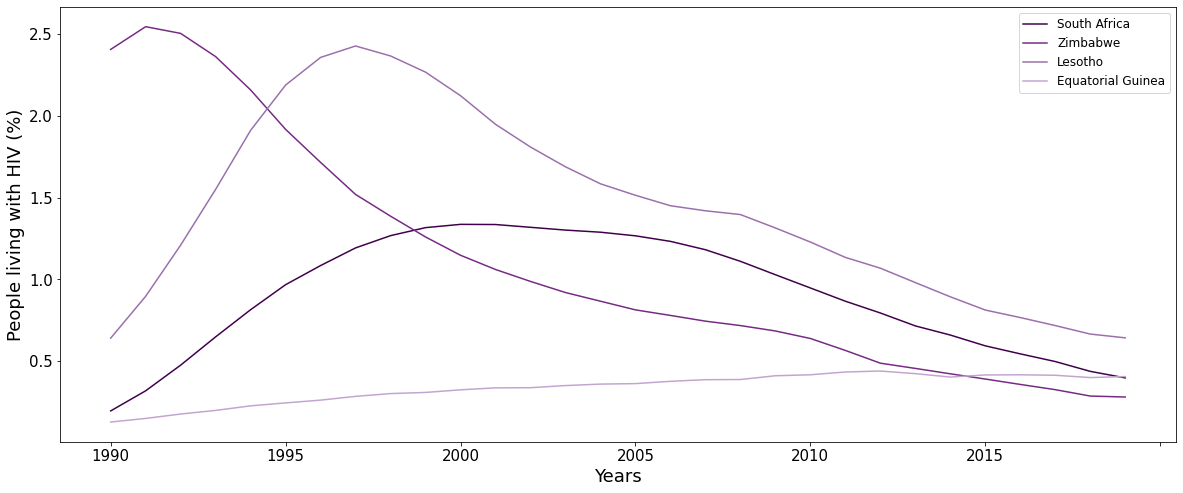

In [16]:
#Plot the HIV vs year data for four representative countries.
hiv_percent_selected_states = hiv_percent.loc[['South Africa','Zimbabwe','Lesotho','Equatorial Guinea'],:];
hiv_percent_selected_states.T.plot();
plt.legend(bbox_to_anchor=(1, 1.0));
plt.xlabel('Years');
plt.ylabel('People living with HIV (%)');

From the above graph it seems that PC1 is linked to the initial part of the curve. Zimbabwe started with a high value of people living with HIV and since the year 1991 this number has been decreasing. On the contrary, South Africa, despite starting from a much smaller value than Zimbabwe in 1990. However, the number of people kept increasing throughout the decade 1990-2000 and only started decreasing signifincantly in 2005.

In the next step I am going to calculate some properties of the data and I will try to link them to the PC1 and PC2. 

In [17]:
#calculate some useful information from the data
change = hiv_percent.iloc[:,-1] - hiv_percent.iloc[:,0] #Final value - initial value
initial_value = hiv_percent.iloc[:,0] 
final_value = hiv_percent.iloc[:,-1]
average = hiv_percent.mean(axis=1)
max_min = hiv_percent.max(axis=1)-hiv_percent.min(axis=1)
mean_change = np.array([]) #Mean of the gradient across the whole timeseries
init_change = np.array([]) #Mean of the gradient for the first 5 elements of the timeseries
final_change = np.array([]) #Mean of the gradient for the last 5 elements of the timeseries
for i in range(hiv_percent.shape[0]):
    mean_change = np.append(mean_change, np.mean(np.gradient(hiv_percent.iloc[i,:])))
    init_change = np.append(init_change, np.mean(np.gradient(hiv_percent.iloc[i,0:5])))
    final_change = np.append(final_change, np.mean(np.gradient(hiv_percent.iloc[i,-5:-1])))
    
mean_change = pd.Series(mean_change, index = hiv_percent.index)
init_change = pd.Series(init_change, index = hiv_percent.index)
final_change = pd.Series(final_change, index = hiv_percent.index)

In [18]:
#append the values calculated above to the PCA
hiv_percent_pca4['change'] = pd.Series(change)
hiv_percent_pca4['init'] = pd.Series(initial_value)
hiv_percent_pca4['final'] = pd.Series(final_value)
hiv_percent_pca4['average'] = pd.Series(average)
hiv_percent_pca4['max_min'] = pd.Series(max_min)
hiv_percent_pca4['mean_change'] = pd.Series(mean_change)
hiv_percent_pca4['init_change'] = pd.Series(init_change)
hiv_percent_pca4['final_change'] = pd.Series(final_change)

Now I use the pariplot options to see if there is any correlation between these values I have just calculated in order to remove the redundant ones.

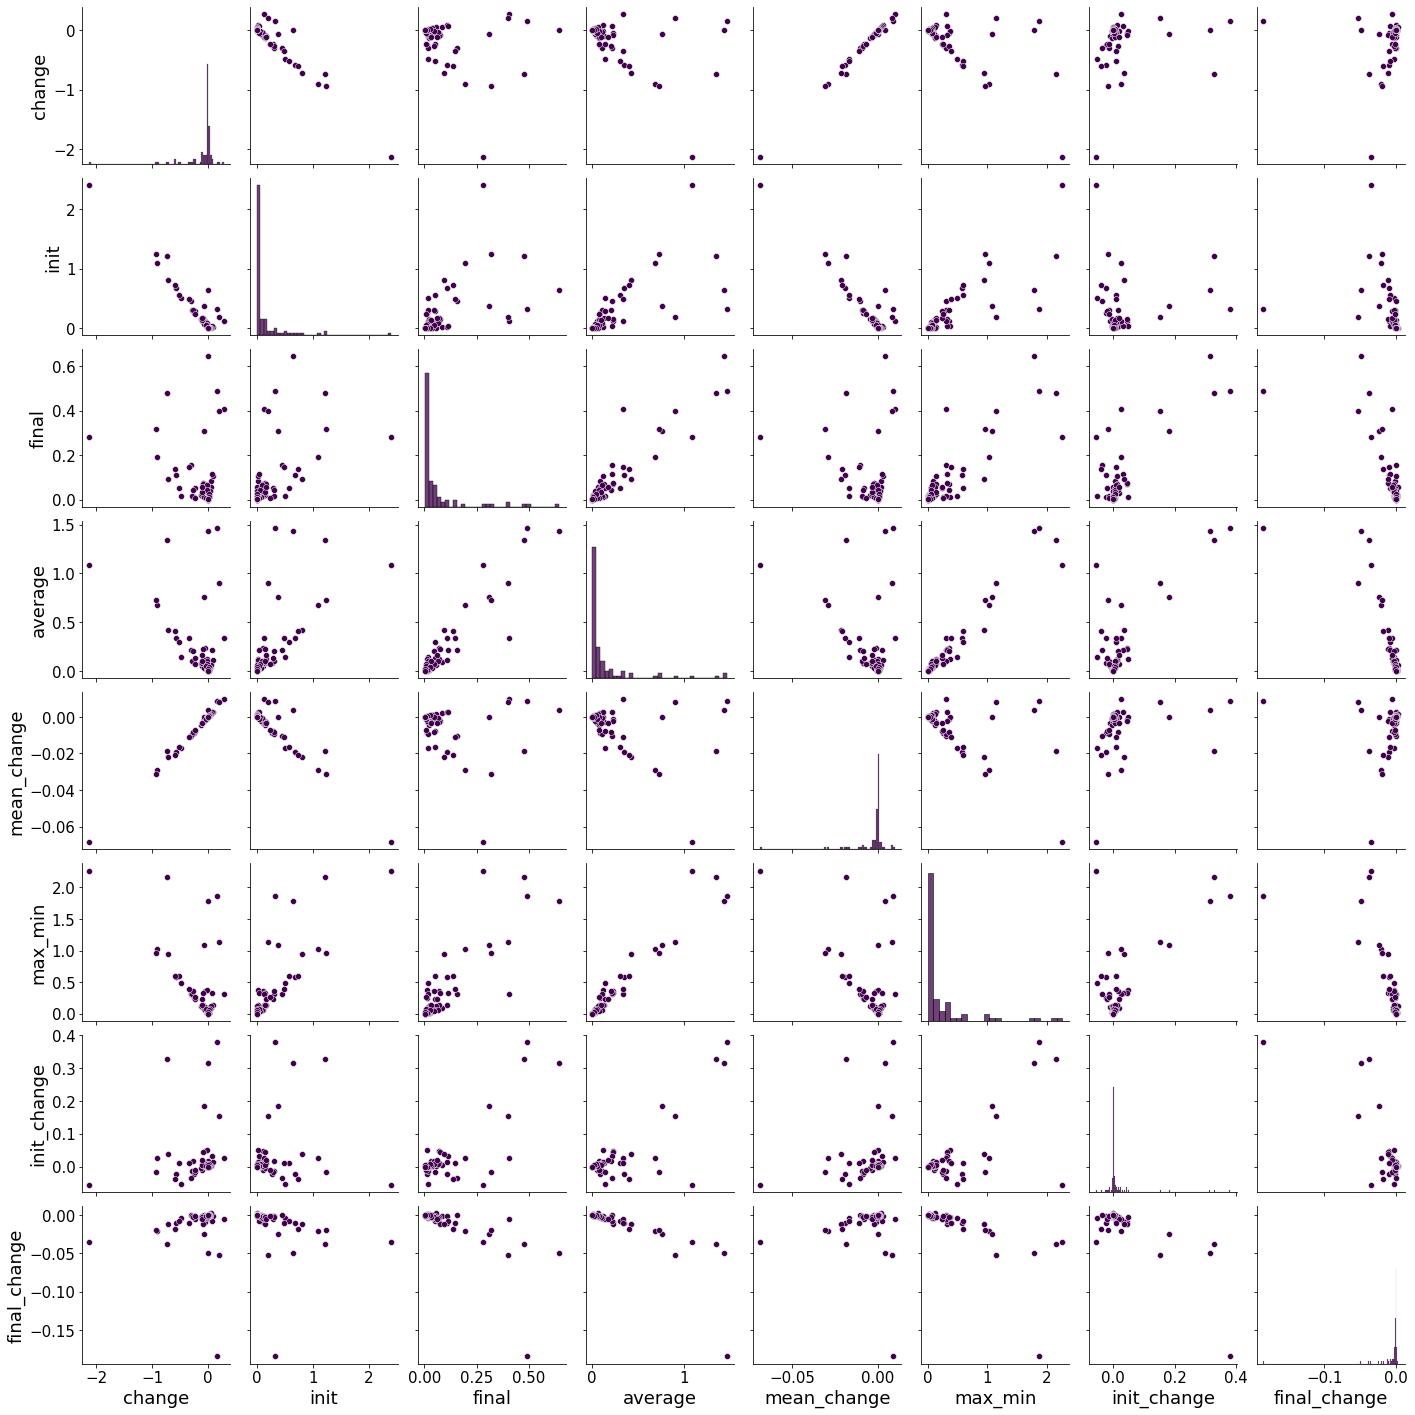

In [19]:
sb.pairplot(hiv_percent_pca4.loc[:,['change','init','final','average','mean_change','max_min','init_change','final_change']])

From the table below I can remove "mean_change" and "intial" since they are both well represented by "change.

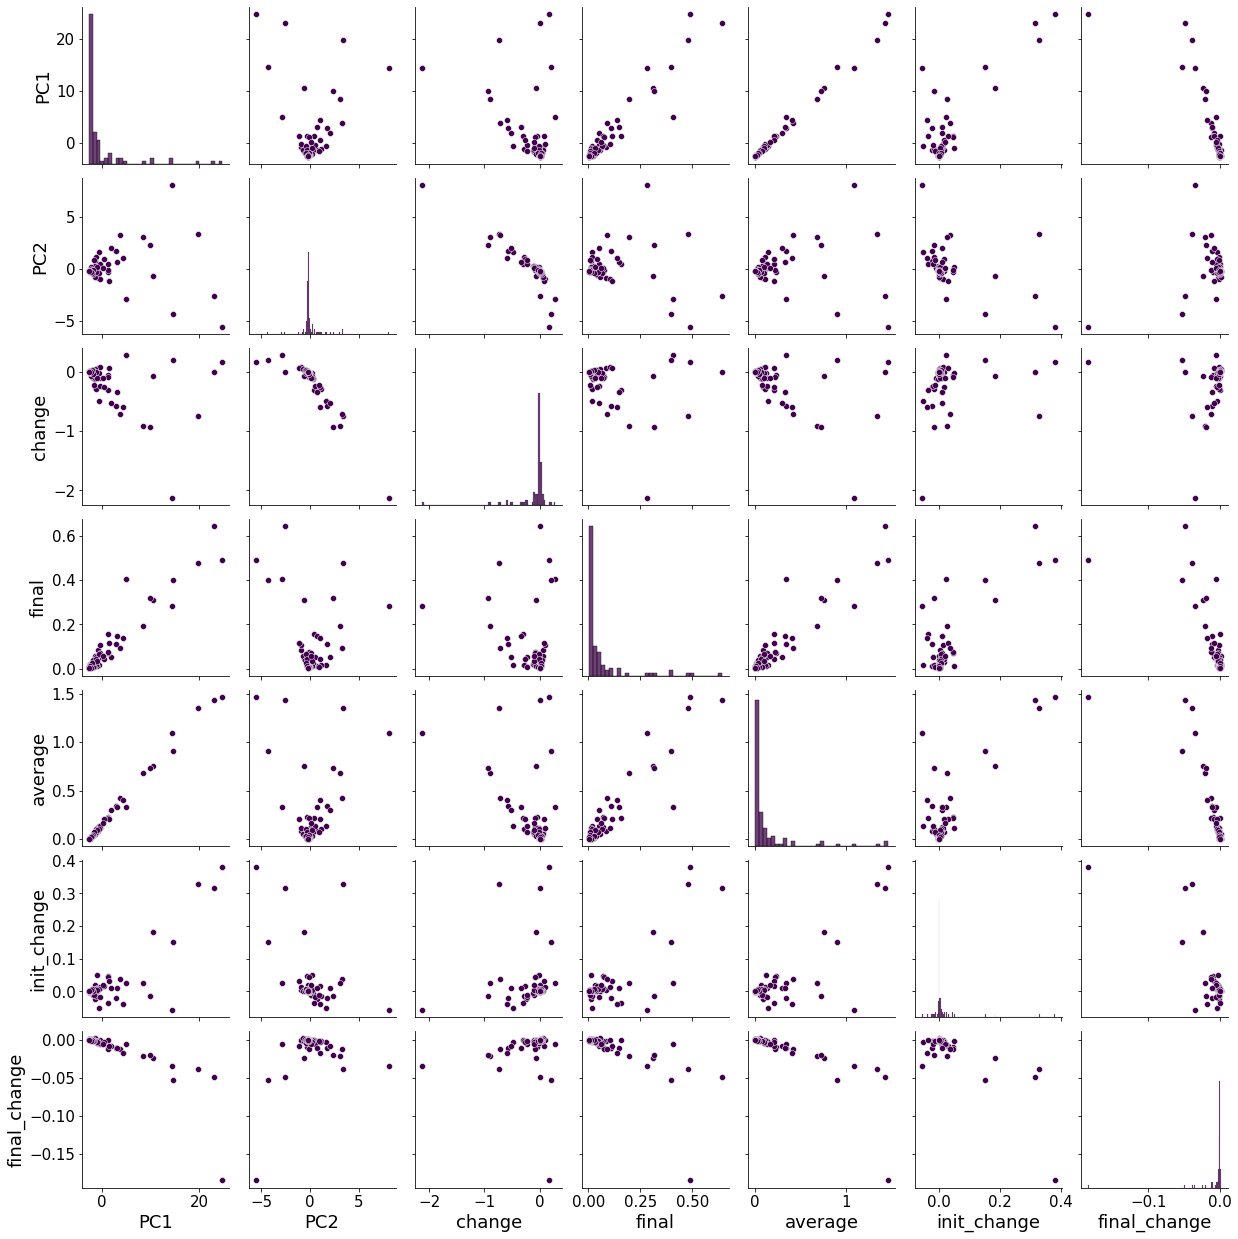

In [20]:
sb.pairplot(hiv_percent_pca4.loc[:,['PC1','PC2','change','final','average','init_change','final_change']])

Fromt the plot above I can coclude that: 

- PC1 is linked to the average value 
- PC2 is linked to the change (final-initial values) 

In the following I will use the average value for HIV for further analysis and discussion as a representation of the HIV dataset for each country. This is justified by the fact that PC1 retains 91.7\% of the dataset variance. 

### Principal component analysis (PCA) on GDP data

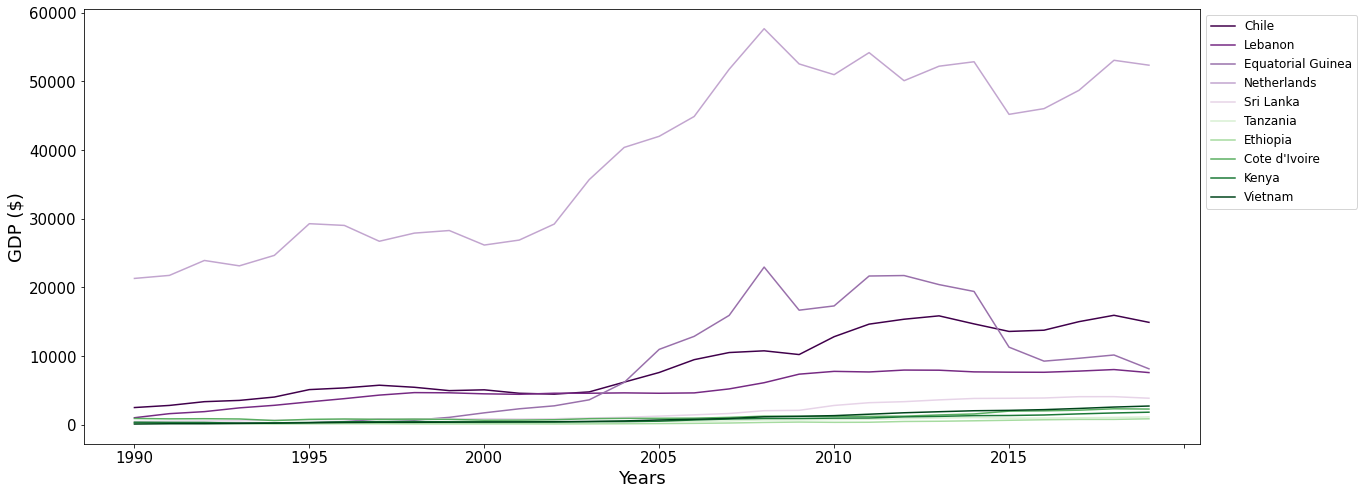

In [21]:
#Let's plot some data now...
#plt.figure();
sample = np.random.choice(gdp_per_capita.index.size, size=10)
gdp_per_capita_sample = gdp_per_capita.iloc[sample,:]
gdp_per_capita_sample.T.plot();
plt.legend(bbox_to_anchor=(1, 1.0))
plt.xlabel('Years');
plt.ylabel('GDP ($)');

,Variance,Cum Variance %,Residual Variance %
Component,,,
1,0.975512,97.551180,2.448820
2,0.014048,98.956026,1.043974
3,0.005363,99.492311,0.507689
4,0.002249,99.717259,0.282741
5,0.001073,99.824523,0.175477


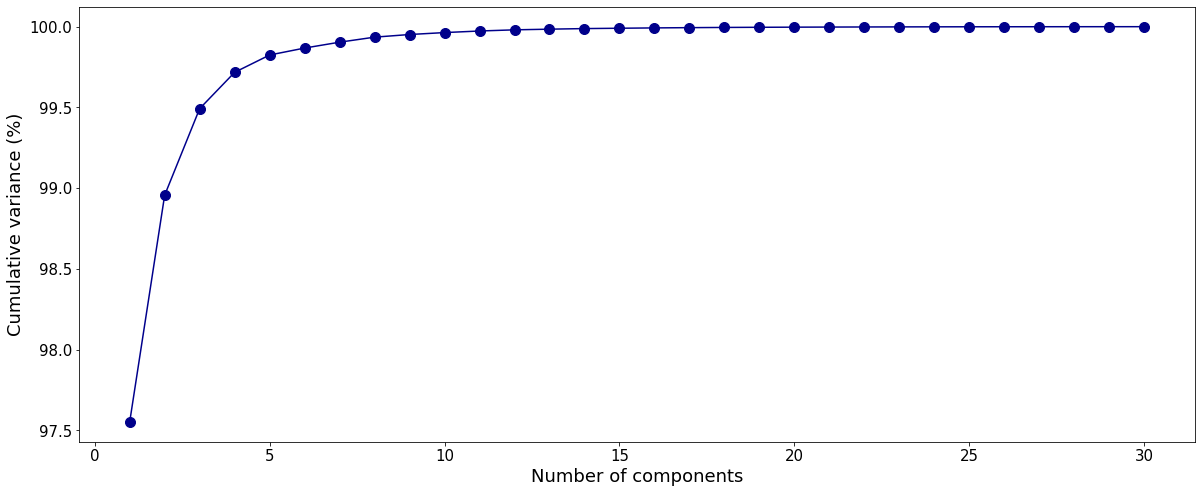

In [22]:
#In order to perform a PCA, the components must be first scaled
gdp_per_capita_scaled = StandardScaler().fit_transform(gdp_per_capita)

#I run to calculate the cumulative variance and choose the number of components to include
pca = PCA()
X_pca = pca.fit(gdp_per_capita_scaled)

#Show the variance in a table
variance_df = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'])
variance_df['Cum Variance %'] = pca.explained_variance_ratio_.cumsum()*100
variance_df['Residual Variance %'] = (1-pca.explained_variance_ratio_.cumsum())*100
variance_df.index += 1
variance_df.index.name = 'Component'
display(variance_df.head())

#Plot the cumulative variance 
plt.plot(variance_df['Cum Variance %'], marker='o', markersize=10, linestyle = '-', c='DarkBlue')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance (%)');

In [23]:
#Now I perform a PCA with four components
num_components = 4
pca = PCA(num_components)  
X_pca = pca.fit_transform(gdp_per_capita_scaled)

#This is saved in a DataFrame and its head is displayed here
gdp_per_capita_pca4 = pd.DataFrame(X_pca, columns =['PC1','PC2','PC3','PC4'] , index = gdp_per_capita.index)
gdp_per_capita_pca4.head()

,PC1,PC2,PC3,PC4
Country Name,,,,
Angola,-1.802631,-0.286582,0.179786,-0.163704
Albania,-1.586707,-0.289482,0.149639,0.176632
Argentina,2.179690,0.460248,-1.024809,-0.398602
Armenia,-1.880123,-0.249946,0.088224,0.016893
Australia,17.383426,-2.542288,0.345814,-1.009569


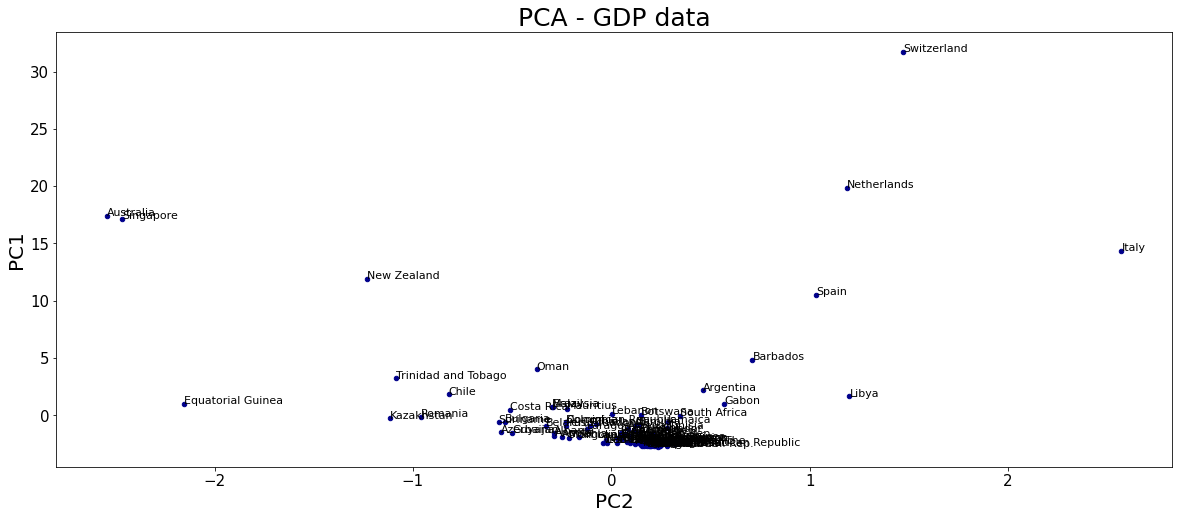

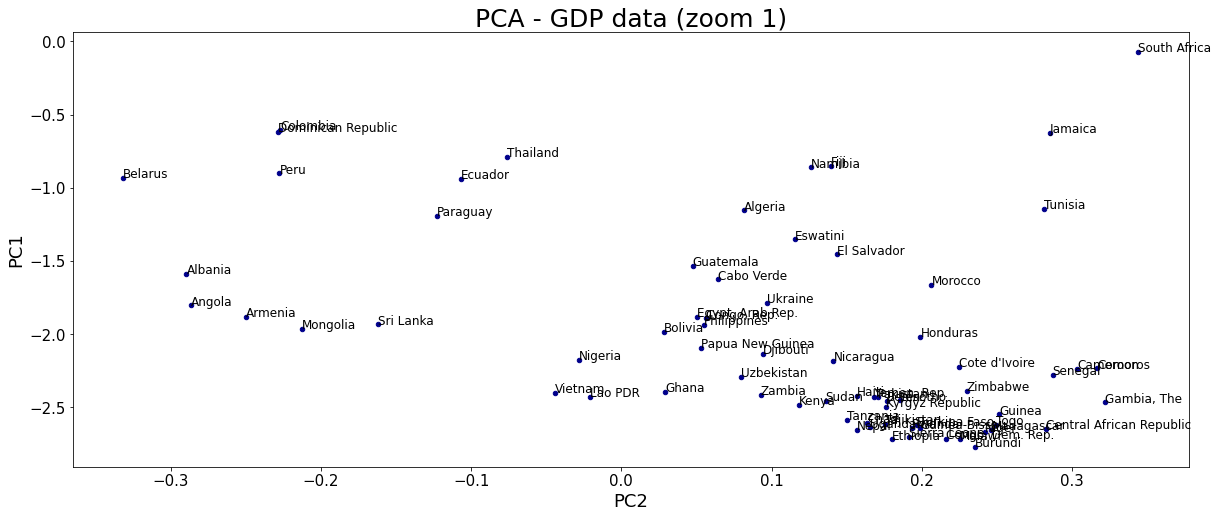

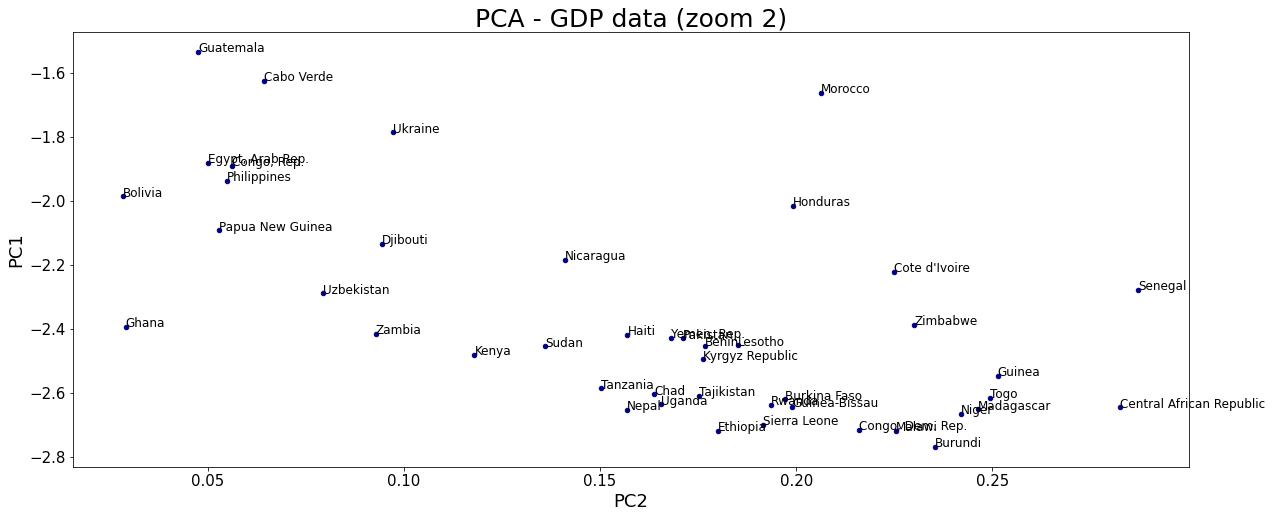

In [24]:
#Display data on a scatter plot for PC1 and PC2 (the PC that retain the highest variance)
#Since most of the points are concentrated in one region, three plots are displayed.
#The first one includes all the data. The second and third are zoom ins of the regions with the highest concentration of datapoints.
gdp_pca_fig = gdp_per_capita_pca4.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

# add country names to the plot
for i, country in enumerate(gdp_per_capita_pca4.index):
    gdp_pca_fig.annotate(country, (gdp_per_capita_pca4.iloc[i].PC2, gdp_per_capita_pca4.iloc[i].PC1),fontsize=11)

gdp_pca_fig.set_xlabel('PC2',fontsize=20);
gdp_pca_fig.set_ylabel('PC1',fontsize=20);
plt.title('PCA - GDP data', size = 25).set_position([.5, 1.])
##############################################
zoom1_df = gdp_per_capita_pca4 
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC1 > 0.0].index)
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC2 > 0.5].index)
zoom1_df = zoom1_df.drop(zoom1_df[zoom1_df.PC2 < -0.5].index)


gdp_pca_fig_zoom1 = zoom1_df.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

for i, country in enumerate(zoom1_df.index):
    gdp_pca_fig_zoom1.annotate(country, (zoom1_df.iloc[i].PC2, zoom1_df.iloc[i].PC1),fontsize=12)

gdp_pca_fig_zoom1.set_xlabel('PC2');
gdp_pca_fig_zoom1.set_ylabel('PC1');
plt.title('PCA - GDP data (zoom 1)', size = 25).set_position([.5, 1.]);
###################################################

zoom2_df = gdp_per_capita_pca4 
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC1 > -1.5].index)
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC2 > 0.3].index)
zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC2 < 0.].index)

#plt.figure();
gdp_pca_fig_zoom2 = zoom2_df.plot(kind='scatter', x='PC2', y='PC1', color='DarkBlue')

for i, country in enumerate(zoom2_df.index):
    gdp_pca_fig_zoom2.annotate(country, (zoom2_df.iloc[i].PC2, zoom2_df.iloc[i].PC1),fontsize=12)

gdp_pca_fig_zoom2.set_xlabel('PC2');
gdp_pca_fig_zoom2.set_ylabel('PC1');
plt.title('PCA - GDP data (zoom 2)', size = 25).set_position([.5, 1.]);

### Extracting information from the PCA

Now I want to visualise the original data for points that have very different values of PC1 and PC2. I choose four countries that represent extreme values of the two PCs keeping the other one constant. Australia and Italy have a similar PC1 value and well separated values for PC2. The opposite is true for Switzerland and Lybia.


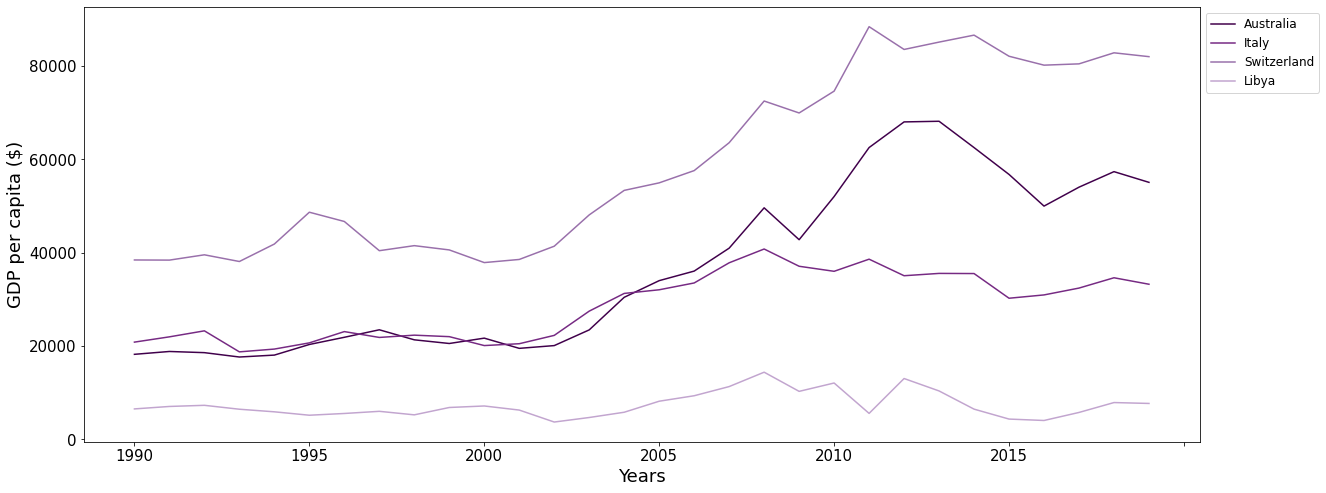

In [25]:
#Plot the HIV vs year data for four representative countries.
gdp_per_capita_selected_states = gdp_per_capita.loc[['Australia','Italy','Switzerland','Libya'],:];
gdp_per_capita_selected_states.T.plot();
plt.legend(bbox_to_anchor=(1, 1.0));
plt.xlabel('Years');
plt.ylabel('GDP per capita ($)');

The above graph suggests that PC1 might be linked to the trend of the GDP in the years 2010 to 2019 where for Australia there has been a significant oscillation, whereas for Italy it has been quite constant. The difference between Switzerland and Libya, PC2 might be linked to the average GDP per capita observed in the analysis time frame. A high value for PC2 would correspond to a high value of PC2.


In [26]:
#calculate some useful information from the data
change = gdp_per_capita.iloc[:,-1] - gdp_per_capita.iloc[:,0] #Final value - initial value
init_value = gdp_per_capita.iloc[:,0]
final_value = gdp_per_capita.iloc[:,-1]
average = gdp_per_capita.mean(axis=1)
max_min = gdp_per_capita.max(axis=1)-gdp_per_capita.min(axis=1)
mean_change = np.array([]) #Mean of the gradient across the whole timeseries
init_change = np.array([]) #Mean of the gradient for the first 5 elements of the timeseries
final_change = np.array([]) #Mean of the gradient for the last 5 elements of the timeseries
for i in range(gdp_per_capita.shape[0]):
    mean_change = np.append(mean_change, np.mean(np.gradient(gdp_per_capita.iloc[i,:])))
    init_change = np.append(init_change, np.mean(np.gradient(gdp_per_capita.iloc[i,0:5])))
    final_change = np.append(final_change, np.mean(np.gradient(gdp_per_capita.iloc[i,-5:-1])))

mean_change = pd.Series(mean_change, index = gdp_per_capita.index)
init_change = pd.Series(init_change, index = gdp_per_capita.index)
final_change = pd.Series(final_change, index = gdp_per_capita.index)

In [27]:
#append the values calculated above to the PCA
gdp_per_capita_pca4['change'] = pd.Series(change)
gdp_per_capita_pca4['init'] = pd.Series(init_value)
gdp_per_capita_pca4['final'] = pd.Series(final_value)
gdp_per_capita_pca4['average'] = pd.Series(average)
gdp_per_capita_pca4['max_min'] = pd.Series(max_min)
gdp_per_capita_pca4['mean_change'] = pd.Series(mean_change)
gdp_per_capita_pca4['init_change'] = pd.Series(init_change)
gdp_per_capita_pca4['final_change'] = pd.Series(final_change)

Now I use the pariplot options to see if there is any correlation between these values I have just calculated in order to remove the redundant ones.

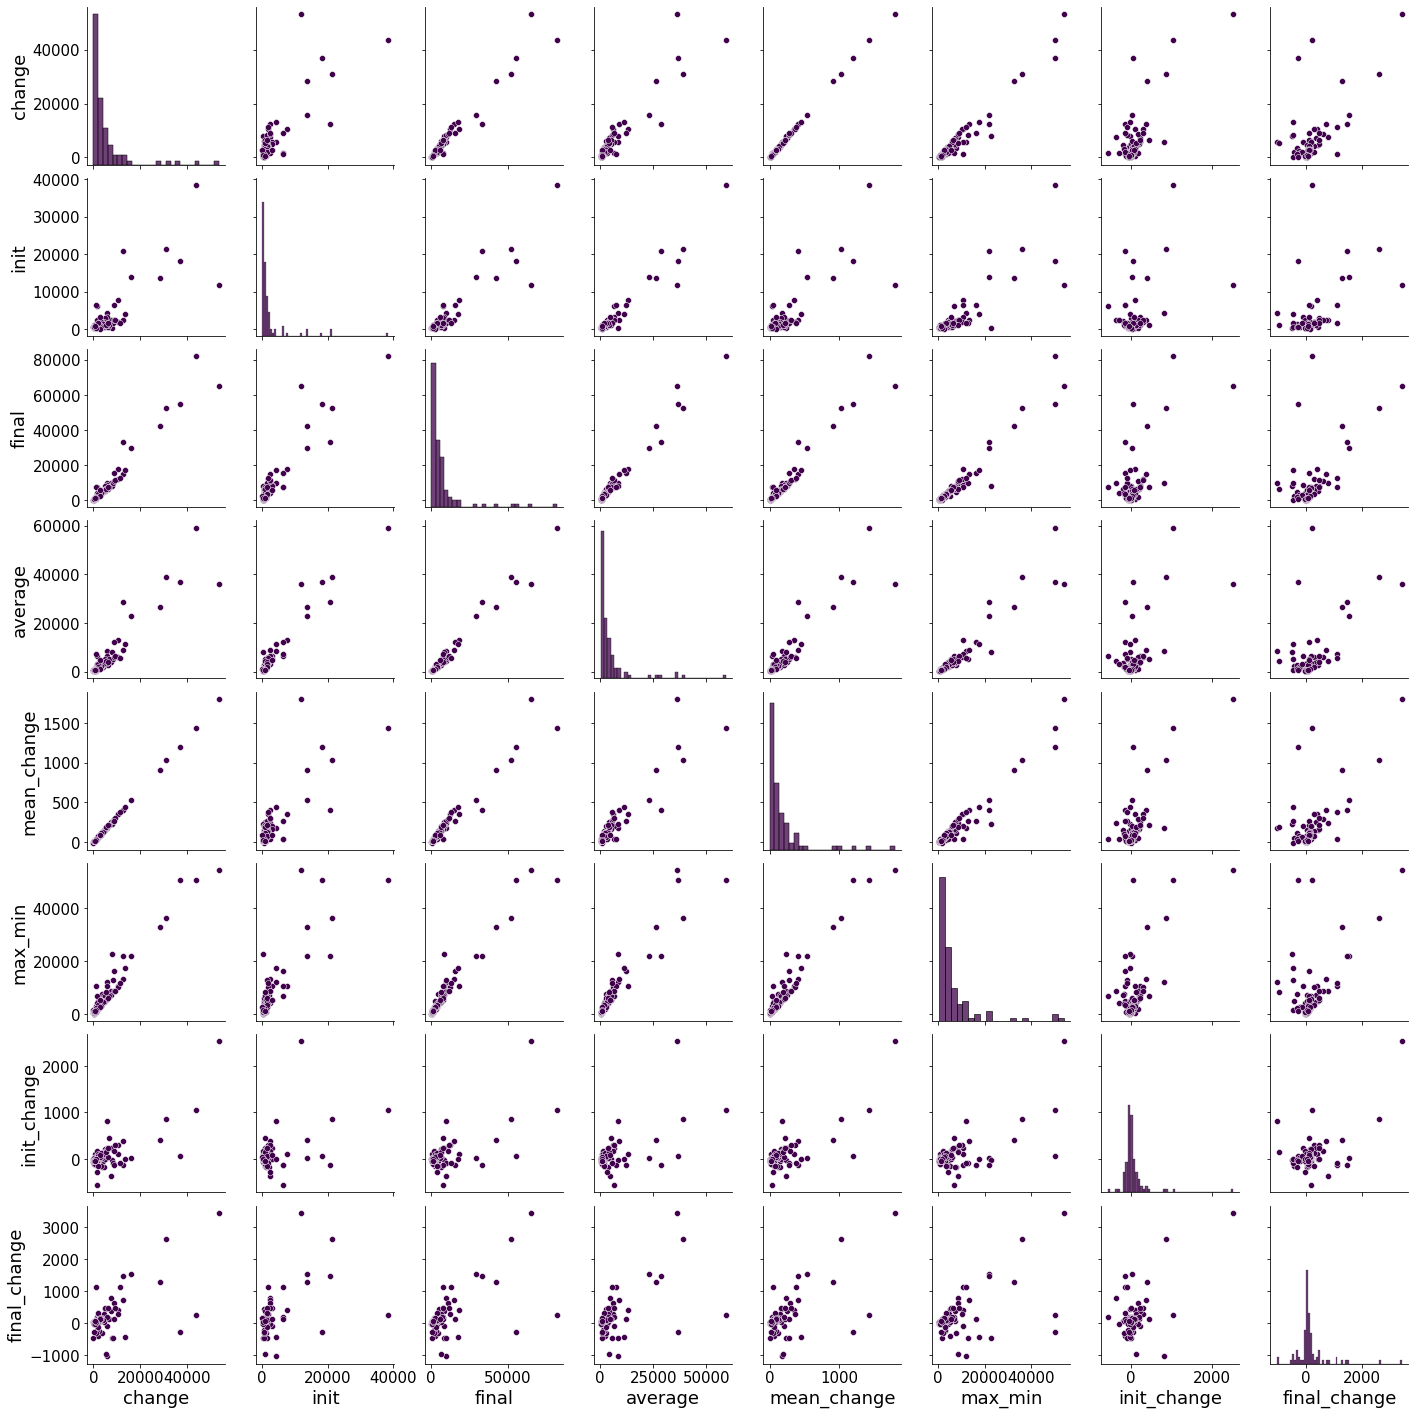

In [28]:
sb.pairplot(gdp_per_capita_pca4.loc[:,['change','init','final','average','mean_change','max_min','init_change','final_change']])

The table above suggests that I can remove "mean_change", "max_min", "final" since they are all well represented by "change".

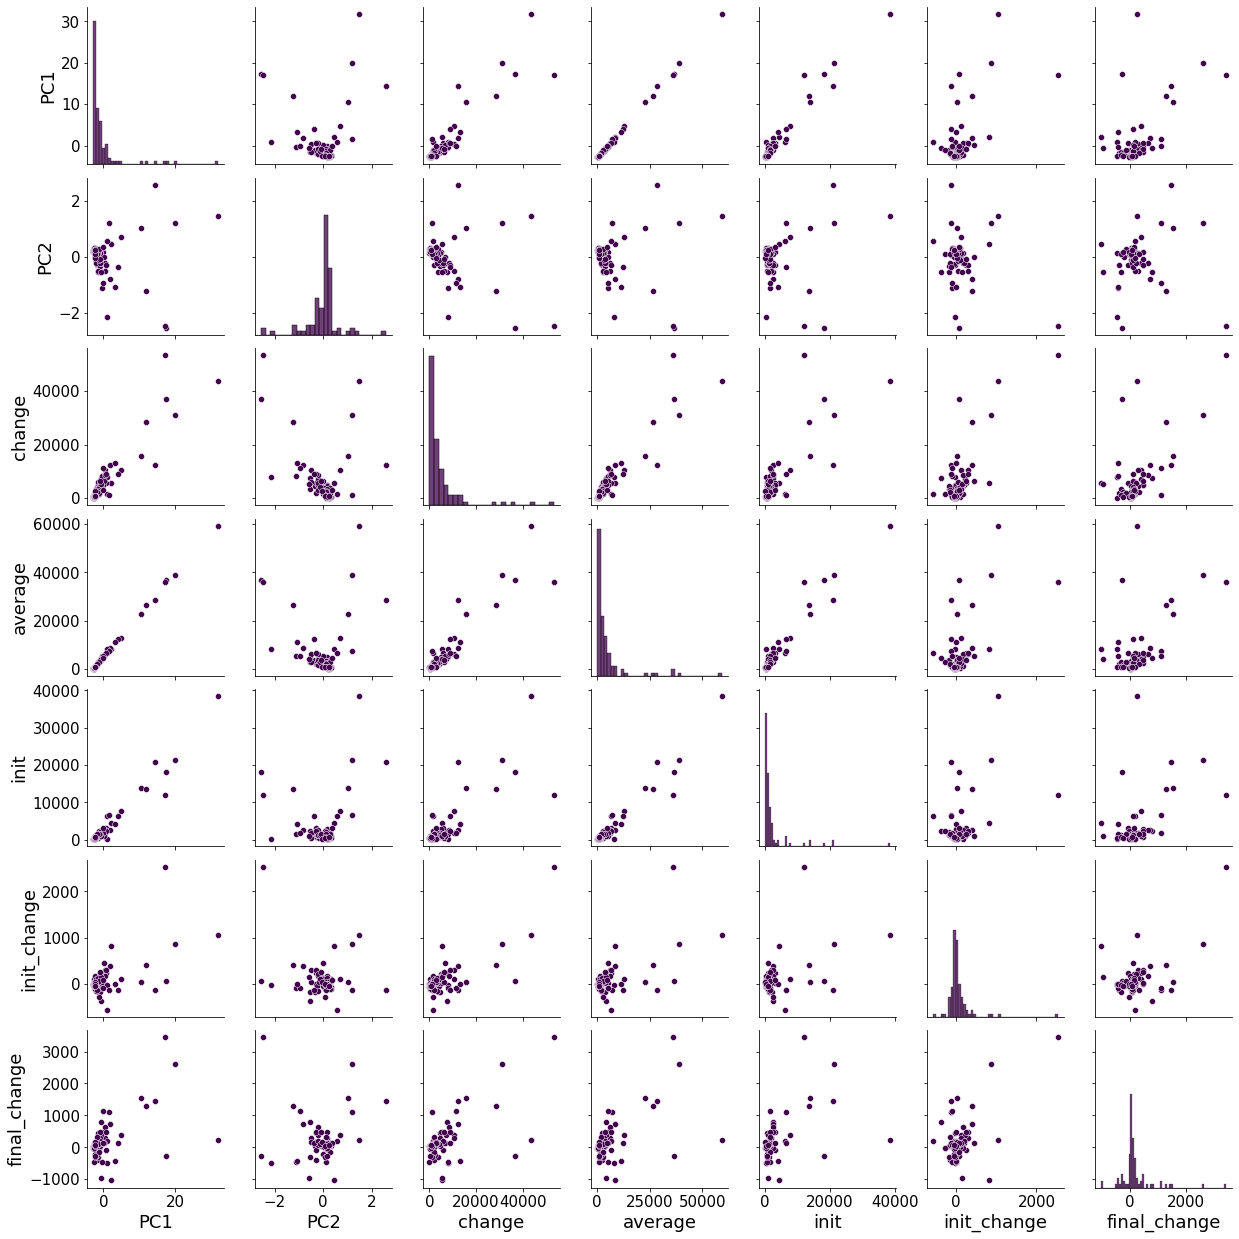

In [29]:
#From above I decide to drop mean_change (keep change), max_min (keep change), initial (keep average)
sb.pairplot(gdp_per_capita_pca4.loc[:,['PC1','PC2','change','average','init','init_change','final_change']])

From above I understand that: 

- PC1 is linked to the average
- None of the properties calculated here can be directly linked to PC2 

In the following I will use the average value for GDP for further analysis and discussion as a representation of the GDP dataset for each country. This is justified by the fact that PC1 retains 97.6\% of the dataset variance. 

## Cluster analysis 

The goal of this analysis is discovering if there are datapoints that can be grouped in the same cluster based on their position in the PC1-PC2 plane. In this study the KMeans algorithm will be used. This is an unsupervised machine learning method. The only parameter that must be defined by the user is the number of clusters. In order to do so we will first calcualte the Within-Cluster-Sum-of-Squares (wcss) and use this as a parameter to identify how many clusters are needed to give a good representation of the dataset. 

In [30]:
#KMeans
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i)
    kmeans_pca.fit(hiv_percent_pca4[['PC1','PC2','PC3','PC4']])
    wcss.append(kmeans_pca.inertia_)

In [31]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i)
    kmeans_pca.fit(hiv_percent_pca4[['PC1','PC2','PC3','PC4']])
    wcss.append(kmeans_pca.inertia_)

The first 10 clusters are plotted in order to identify the elbow point.

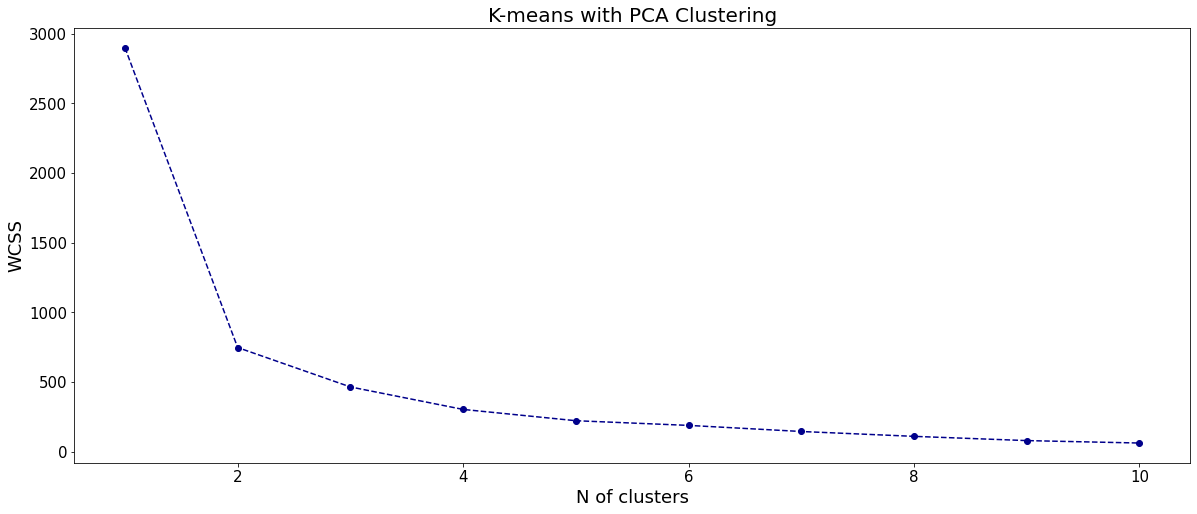

In [32]:
plt.figure();
plt.plot(range(1,11), wcss, color='DarkBlue',marker='o', linestyle = '--')
plt.xlabel('N of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering', size=20)
plt.show()

Based on the graph above I decided to use 2 clusters.

In [33]:
kmeans_pca = KMeans(n_clusters = 3)
clusters = kmeans_pca.fit(hiv_percent_pca4[['PC1','PC2','PC3','PC4']])

In [34]:
#Here I append the cluster value to the dataframes (GDP and HIV) as the last column.
hiv_percent_pca4['cluster'] = pd.Series(clusters.labels_, index=hiv_percent_pca4.index)
gdp_per_capita_pca4['cluster'] = pd.Series(clusters.labels_, index=hiv_percent_pca4.index)
#hiv_clusters = hiv_percent.copy(deep=True)

<Figure size 1440x576 with 0 Axes>

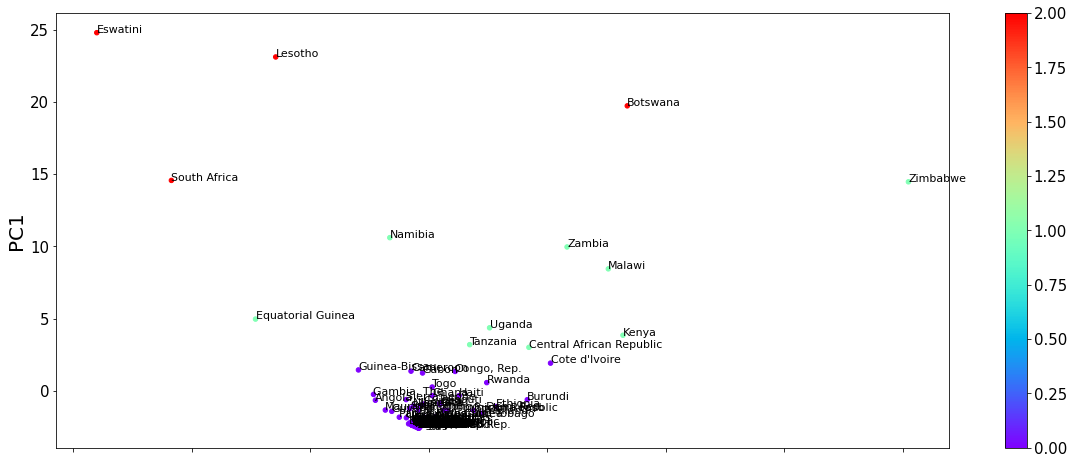

In [35]:
plt.figure();

hiv_percent_cluster = hiv_percent_pca4.plot(kind='scatter', x='PC2', y='PC1', c=hiv_percent_pca4['cluster'], cmap='rainbow');

# add country names to the plot
for i, country in enumerate(hiv_percent_pca4.index):
    hiv_percent_cluster.annotate(country, (hiv_percent_pca4.iloc[i].PC2, hiv_percent_pca4.iloc[i].PC1),fontsize=11)

hiv_percent_cluster.set_xlabel('PC2',fontsize=20);
hiv_percent_cluster.set_ylabel('PC1',fontsize=20);

# Is there an easy to explain correlation in the data?

In this section the goal is to verify whether there is an easy correlation between the percentage of the population living with HIV and the GDP of the country.


In [36]:
#Create a list of the countries that belong to different clusters
countries_0 = hiv_percent_pca4[hiv_percent_pca4.cluster == 0].index
countries_1 = hiv_percent_pca4[hiv_percent_pca4.cluster == 1].index
countries_2 = hiv_percent_pca4[hiv_percent_pca4.cluster == 2].index

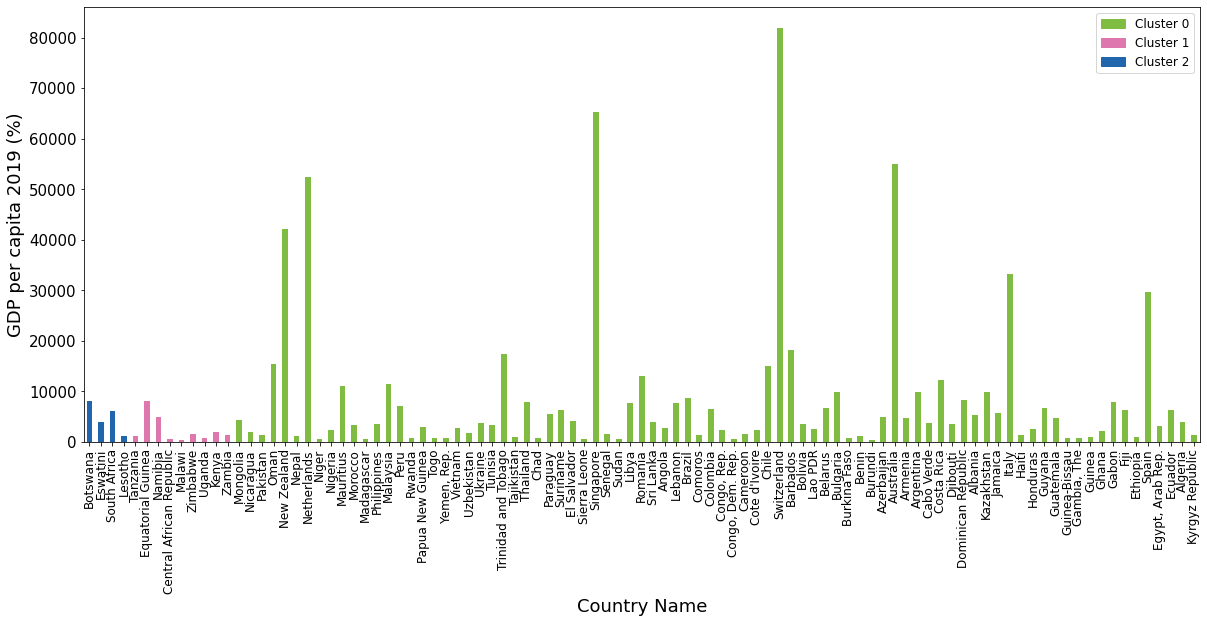

In [37]:
import matplotlib.patches as mpatches
c1 = '#7fbc41'
c2 = '#de77ae'
c3 = '#2166ac'
#The values of average GDP per country and color the bars with one color for cluster
#Let's do 3 plots, one for cluster and place then next to each other
cluster_df = gdp_per_capita_pca4.sort_values('cluster',axis=0, ascending=False)
#cluster2_df = gdp_per_capita_pca4[gdp_per_capita_pca4.cluster == 2]
colors = {0: c1, 1: c2, 2: c3}
hist_cluster = cluster_df['final'].plot.bar(color=[colors[i] for i in cluster_df['cluster']]);
plt.xticks(rotation=90, size = 12)
plt.ylabel('GDP per capita 2019 (%)')
cl_0 = mpatches.Patch(color=c1, label='Cluster 0')
cl_1 = mpatches.Patch(color=c2, label='Cluster 1')
cl_2 = mpatches.Patch(color=c3, label='Cluster 2')
plt.legend(handles=[cl_0, cl_1, cl_2], loc=1)
#hist_cluster3 = cluster2_df['average'].plot.(color = "yellow");
#zoom2_df = zoom2_df.drop(zoom2_df[zoom2_df.PC1 > -1.5].index)
#df.tail(50)
#list(gdp_per_capita_pca4['cluster'])

From the graph above I conclude that:

- The countries blonging to the cluster 2 and 1 (characterised by having a higher average number of people living with HIV) are all low-medium income countries.
- The countries belonging to the 0 cluster (characterised by having a lower average number of people living with HIV) include low-medium and high income countries. As a matter of fact both the highest GDP (Switzerland) and lowest GDP (Burundi) are both in this cluster. 

While the first observation suggests that the GDP per capita of a country might partly explain some of the factors that cause the HIV global pandemic to be higher in certain countries, The second observation indicates that that GDP alone is not an adequate indicator to explain the HIV global pandemic. 
The same data is plotted in descending order of GDP in the bar plot below.


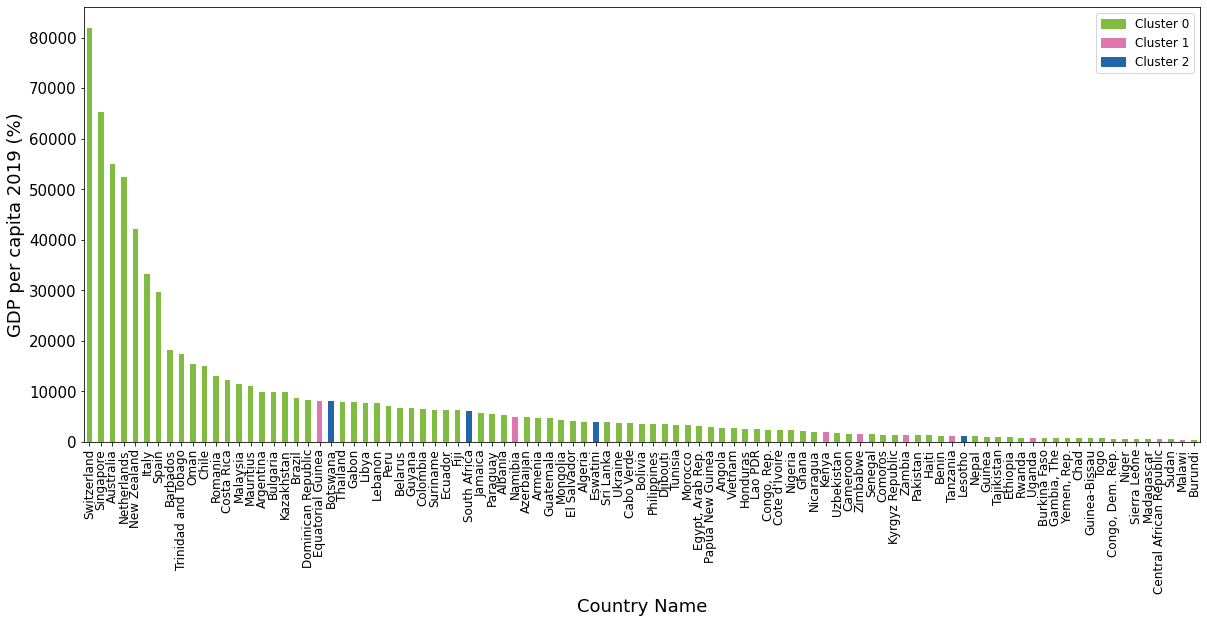

In [38]:
cluster_df_gdp_ordered = gdp_per_capita_pca4.sort_values('final',axis=0, ascending=False)
#cluster2_df = gdp_per_capita_pca4[gdp_per_capita_pca4.cluster == 2]
colors = {0: c1, 1: c2, 2: c3}
hist_cluster_gdp_ordered = cluster_df_gdp_ordered['final'].plot.bar(color=[colors[i] for i in cluster_df_gdp_ordered['cluster']]);
plt.xticks(rotation=90, size = 12)
plt.ylabel('GDP per capita 2019 (%)')
cl_0 = mpatches.Patch(color=c1, label='Cluster 0')
cl_1 = mpatches.Patch(color=c2, label='Cluster 1')
cl_2 = mpatches.Patch(color=c3, label='Cluster 2')
plt.legend(handles=[cl_0, cl_1, cl_2], loc=1)

# Conclusions

In this excercise, the correlation between the percentage of population having HIV/AIDS and the GDP per capita was investigated by using statistical methods. First the data was cleaned in order to have two dataset including the same countries and the same time frame. This resulted in a dataset of 73 countries and 30 years (1990-2019). 

Then a PCA was performed in order to reduce the dimensionality of both datasets. The first four components were observed retaining more than 99\% of the variance for the HIV and GDP data. Therefore, the analysis was focussed on the first four PCs. Some of the time series properties (such as average, gradient, initial and final values) were calculated in order to try to extract information from the PCA.

Finally, in order to try to find a correlation between the HIV/AIDS percentage of the population and the GDP per capita of a country, a cluster analysis was performed on the HIV data. Three main clusters were identified. An histogram of the 2019 GDP per capita was plotted trying to highlight a link witht the percentage of HIV. Although it was observed that the countries characterised by the highest values of HIV (estimated as average in the time frame 1990-2019) are all low-middle income countries, this was not enough to confirm a link HIV-GDP. Most of the countries (used in this study) belonged to the same cluster. This cluster is characterised by a low percentage of HIV. However, this cluster included countries with all levels of income (including the highest and lowest).

In conclusion, the analysis discussed here showed that a simple HIV-GDP correlation cannot be established. The HIV global epidemic is a very complicated and multi faceted problem. In order to gain a better understanding of this problem, in a future study the following aspects could be investigated:

- Access to antiretroviral treatment: these drugs lower the amount of virus in the body and increase the life expectancy by several decades. These are two opposing effects since the former will lower the number of new infections and the latter will increase the number of people living with HIV.
- Education: this is essential (in particualar sexual education) in order for people to understand what the risk factors related to HIV are. It also helps fight the stigma that is linked to having HIV both in low-middle income countries and high income ones.
- Level of inequality within the country: for example Gini coefficient. In this study, only the GDP per capita was used. However, this assumes that the wealth is distributed equally among the whole population.

REFERENCES
(COLOR PALETTE) https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3